In [1]:
from scripts.fetch_data import fetch_data
from scripts.preprocessing import clean_data, calculate_returns, visualize_data, print_summary
from scripts.eda import load_data, analyze_returns,analyze_volatility, analyze_cumulative_returns
from scripts.portfolio_analysis import calculate_var, calculate_cvar, calculate_drawdown, visualize_drawdown,visualize_var_cvar
from scripts.portfolio_optimization import portfolio_performance, minimize_volatility, negative_sharpe_ratio, efficient_frontier, plot_efficient_frontier
from scipy.optimize import minimize
import pandas as pd
import numpy as np
import datetime
import os

In [ ]:
# Get user input for tickers and date range (assuming basic input handling)
tickers = input("Enter comma-separated ticker symbols (e.g., AAPL,MSFT,GOOGL): ").split(",")
start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")

# Download data
data = fetch_data(tickers, start_date, end_date)

# Check if data download was successful
if data is not None:
  # Clean data
  data = clean_data(data)

  # Calculate returns
  returns = calculate_returns(data)

  # Get current timestamp
  now = datetime.datetime.now()
  timestamp = now.strftime("%Y-%m-%d_%H-%M-%S") 

  # Save raw data
  folder_name = 'data'
  if not os.path.exists(folder_name):
    os.makedirs(folder_name)

  data.to_csv(os.path.join(folder_name, f'raw_data-{timestamp}.csv'))

  # Save processed data
  data['Close'].to_csv(os.path.join(folder_name, f'historical_close_prices-{timestamp}.csv'))
  returns.to_csv(os.path.join(folder_name, f'daily_returns-{timestamp}.csv'))

  # Visualize and print summary
  visualize_data(data, returns)

else:
  print("Failed to retrieve data. Please check ticker symbols and date range.") 

In [ ]:
df = data['Close']
print_summary(df, tickers, start_date, end_date)

In [2]:
# Get user input for file paths
close_prices_file = input("Enter the path for the historical prices file (e.g., historical_prices.csv): ")
returns_file = input("Enter the path for the daily returns file (e.g., daily_returns.csv): ")

# Load price and return data
close_prices_data = load_data(close_prices_file)
returns_data = load_data(returns_file)

if close_prices_data is not None and returns_data is not None:
    # Summary statistics
    print("Price Data Summary:")
    print(close_prices_data.describe())

    print("\nReturns Data Summary:")
    print(returns_data.describe())

Price Data Summary:
             AAPL       GOOGL        NFLX
count  253.000000  253.000000  253.000000
mean    92.939054   73.682551  446.827233
std     21.468006    8.726527   65.612631
min     54.509758   52.516125  298.839996
25%     75.045219   69.606171  381.049988
50%     89.287987   73.688377  469.959991
75%    112.991776   77.946930  495.989990
max    133.662994   90.918907  556.549988

Returns Data Summary:
             AAPL       GOOGL        NFLX
count  252.000000  252.000000  252.000000
mean     0.002728    0.001276    0.002387
std      0.029418    0.024242    0.029146
min     -0.128647   -0.116342   -0.111389
25%     -0.010434   -0.008225   -0.013407
50%      0.001655    0.003275    0.001268
75%      0.017074    0.013565    0.017654
max      0.119808    0.092412    0.116087


In [ ]:
analyze_returns(returns_data)

In [ ]:
analyze_volatility(returns_data)

In [ ]:
analyze_cumulative_returns(returns_data)

In [3]:
risk_free_rate = float(input("Enter the annualized risk-free rate (e.g., 0.02 for 2%): ")) / 252
confidence_level = float(input("Enter the confidence level (e.g., 0.95 for 95%): "))

returns = pd.read_csv(returns_file, index_col='Date', parse_dates=True)

Var = calculate_var(returns, confidence_level)
cVar = calculate_cvar(returns, confidence_level)
# Sharpe_ratio = calculate_sharpe_ratio(returns, risk_free_rate)
Drawdown = calculate_drawdown(returns)
max_drawdown = Drawdown.min()

In [ ]:
visualize_drawdown(Drawdown)

In [ ]:
visualize_var_cvar(returns, Var, cVar, confidence_level)

In [4]:
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_assets = len(mean_returns)
initial_weights = np.array([1.0 / num_assets] * num_assets)

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Sum of weights = 1
bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling

portfolio_return, portfolio_volatility, portfolio_sharpe_ratio = portfolio_performance(initial_weights, mean_returns, cov_matrix, risk_free_rate)

print("\nPortfolio Performance with initial weights")
print("Expected Portfolio Return:", portfolio_return)
print("Portfolio Volatility:", portfolio_volatility)
print("Portfolio Sharpe Ratio:", portfolio_sharpe_ratio)


Portfolio Performance with initial weights
Expected Portfolio Return: 0.5367764154732437
Portfolio Volatility: 0.3769693184734145
Portfolio Sharpe Ratio: 1.4237154699149044


In [5]:
# Step 4: Optimize Portfolio for Sharpe Ratio
optimal_sharpe = minimize(
    negative_sharpe_ratio,
    x0=initial_weights,
    args=(mean_returns, cov_matrix, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
optimal_weights_sharpe = optimal_sharpe.x

# Step 5: Optimize Portfolio for Minimum Volatility
optimal_volatility = minimize(
    minimize_volatility,
    x0=initial_weights,
    args=(mean_returns, cov_matrix, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)
optimal_weights_volatility = optimal_volatility.x

print("\nOptimal Weights for Max Sharpe Ratio Portfolio:")
print(optimal_weights_sharpe)
print("\nOptimal Weights for Min Volatility Portfolio:")
print(optimal_weights_volatility)

# Step 6: Calculate Portfolio Performance with Optimal Weights
portfolio_return_sharpe, portfolio_volatility_sharpe, portfolio_sharpe_ratio_sharpe = portfolio_performance(optimal_weights_sharpe, mean_returns, cov_matrix, risk_free_rate)
portfolio_return_volatility, portfolio_volatility_volatility, portfolio_sharpe_ratio_volatility = portfolio_performance(optimal_weights_volatility, mean_returns, cov_matrix, risk_free_rate)

print("\nPortfolio Performance with Optimal Weights for Max Sharpe Ratio:")
print("Expected Portfolio Return:", portfolio_return_sharpe)
print("Portfolio Volatility:", portfolio_volatility_sharpe)
print("Portfolio Sharpe Ratio:", portfolio_sharpe_ratio_sharpe)

print("\nPortfolio Performance with Optimal Weights for Min Volatility:")
print("Expected Portfolio Return:", portfolio_return_volatility)
print("Portfolio Volatility:", portfolio_volatility_volatility)
print("Portfolio Sharpe Ratio:", portfolio_sharpe_ratio_volatility)


Optimal Weights for Max Sharpe Ratio Portfolio:
[0.60700351 0.         0.39299649]

Optimal Weights for Min Volatility Portfolio:
[0.00680521 0.68307909 0.31011571]

Portfolio Performance with Optimal Weights for Max Sharpe Ratio:
Expected Portfolio Return: 0.6535972210484874
Portfolio Volatility: 0.4134840189534719
Portfolio Sharpe Ratio: 1.5805153911949874

Portfolio Performance with Optimal Weights for Min Volatility:
Expected Portfolio Return: 0.4108228123429676
Portfolio Volatility: 0.3621266137464558
Portfolio Sharpe Ratio: 1.134253688272649


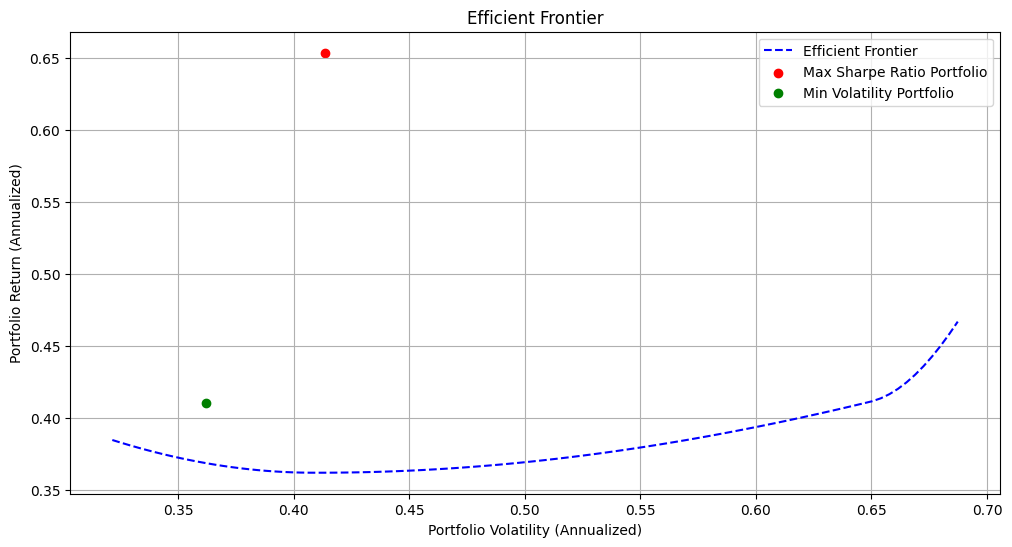

In [6]:
frontier_returns, frontier_volatilities = efficient_frontier(mean_returns, cov_matrix, risk_free_rate)

plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, optimal_weights_sharpe, optimal_weights_volatility, frontier_returns, frontier_volatilities)